## **Installation**

In [1]:
!pip -q install umap-learn xgboost


## 2.**Imports** **bold text**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
%matplotlib inline


## **3.Load Dataset**

In [3]:
path = "/content/heart.csv"
df = pd.read_csv(path)

print("Shape:", df.shape)
display(df.head())
print("\nColumns:\n", df.columns.tolist())


Shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0



Columns:
 ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


## 4.**Target check + split X/y**

---



In [4]:
# Auto-detect target column
possible_targets = ["target", "Target", "TARGET", "output", "Outcome", "label", "Label"]
target_col = None
for c in possible_targets:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    raise ValueError("❌ Could not find target column. Please tell me your target column name.")

print("✅ Using target column:", target_col)
print(df[target_col].value_counts())

X = df.drop(columns=[target_col]).copy()
y = df[target_col].astype(int).copy()
feature_names = X.columns.tolist()


✅ Using target column: target
target
1    526
0    499
Name: count, dtype: int64


## **5.Handle missing values + train/test split + scaling**





In [5]:
# Replace any non-numeric junk (like '?') safely, then convert
X = X.replace("?", np.nan)

# Convert all columns to numeric if possible
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors="coerce")

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

imputer = SimpleImputer(strategy="median")
X_train_imp = imputer.fit_transform(X_train_raw)
X_test_imp  = imputer.transform(X_test_raw)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled  = scaler.transform(X_test_imp)

print("✅ Preprocessing done.")
print("Train:", X_train_scaled.shape, "Test:", X_test_scaled.shape)


✅ Preprocessing done.
Train: (820, 13) Test: (205, 13)


## **DR + plotting helpers**

In [6]:
def get_dr_embeddings(X_scaled, method="pca", random_state=42):
    if method == "none":
        return X_scaled
    if method == "pca":
        return PCA(n_components=2, random_state=random_state).fit_transform(X_scaled)
    if method == "tsne":
        return TSNE(
            n_components=2, perplexity=30, learning_rate="auto",
            init="pca", random_state=random_state
        ).fit_transform(X_scaled)
    if method == "umap":
        return umap.UMAP(n_components=2, random_state=random_state).fit_transform(X_scaled)
    raise ValueError("Unknown DR method")

def plot_2d(X_2d, labels, title):
    plt.figure(figsize=(7,6))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, s=25)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.colorbar(label="Cluster ID")
    plt.tight_layout()
    plt.show()


## **7.Clustering + metrics helpers**

In [7]:
def safe_cluster_scores(X_emb, labels):
    uniq = set(labels)
    if len(uniq) <= 1:
        return None

    # DBSCAN noise case
    if -1 in uniq:
        mask = labels != -1
        if mask.sum() < 10:
            return None
        X_nn = X_emb[mask]
        y_nn = labels[mask]
        if len(set(y_nn)) <= 1:
            return None
        sil = silhouette_score(X_nn, y_nn)
        dbi = davies_bouldin_score(X_nn, y_nn)
        chi = calinski_harabasz_score(X_nn, y_nn)
        return sil, dbi, chi

    sil = silhouette_score(X_emb, labels)
    dbi = davies_bouldin_score(X_emb, labels)
    chi = calinski_harabasz_score(X_emb, labels)
    return sil, dbi, chi

def run_clustering(X_emb, algo, k=3, eps=0.8, min_samples=5, random_state=42):
    if algo == "kmeans":
        return KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit_predict(X_emb)
    if algo == "hierarchical":
        return AgglomerativeClustering(n_clusters=k).fit_predict(X_emb)
    if algo == "dbscan":
        return DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X_emb)
    raise ValueError("Unknown clustering algorithm")


## **8.Benchmark ALL combinations (DR × Clustering)**





In [8]:
dr_methods = ["none", "pca", "tsne", "umap"]
cluster_algos = ["kmeans", "hierarchical", "dbscan"]

rows = []
for dr in dr_methods:
    X_emb = get_dr_embeddings(X_train_scaled, method=dr, random_state=42)

    for algo in cluster_algos:
        if algo in ["kmeans", "hierarchical"]:
            for k in [2, 3, 4, 5]:
                labels = run_clustering(X_emb, algo=algo, k=k, random_state=42)
                scores = safe_cluster_scores(X_emb, labels)
                if scores is None:
                    continue
                sil, dbi, chi = scores
                rows.append([dr, algo, f"k={k}", sil, dbi, chi, len(set(labels))])

        if algo == "dbscan":
            for eps in [0.3, 0.5, 0.7, 0.9, 1.1]:

                labels = run_clustering(X_emb, algo=algo, eps=eps, min_samples=5, random_state=42)
                scores = safe_cluster_scores(X_emb, labels)
                if scores is None:
                    continue
                sil, dbi, chi = scores
                rows.append([dr, algo, f"eps={eps}", sil, dbi, chi, len(set(labels))])

bench = pd.DataFrame(rows, columns=[
    "DR", "Clustering", "Params", "Silhouette(↑)", "DBI(↓)", "CH(↑)", "NumClusters"
]).sort_values("Silhouette(↑)", ascending=False).reset_index(drop=True)

print("✅ Benchmark completed. Top 10 results:")
display(bench.head(10))


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Benchmark completed. Top 10 results:


,DR,Clustering,Params,Silhouette(↑),DBI(↓),CH(↑),NumClusters
0,none,dbscan,eps=0.3,0.988098,0.019059,10570.870902,3
1,none,dbscan,eps=0.5,0.961740,0.074109,2429.009611,4
2,none,dbscan,eps=0.7,0.961740,0.074109,2429.009611,4
3,none,dbscan,eps=0.9,0.893381,0.208094,468.488448,7
4,umap,dbscan,eps=0.5,0.884399,0.140267,26436.375000,57
5,umap,dbscan,eps=0.7,0.884028,0.138015,18050.896484,54
6,umap,dbscan,eps=0.9,0.879158,0.142355,15126.621094,51
7,umap,dbscan,eps=0.3,0.878415,0.137301,54417.597656,66
8,umap,dbscan,eps=1.1,0.874334,0.149960,13108.359375,50
9,none,dbscan,eps=1.1,0.658597,0.543025,154.519434,12


## **9.Plot TOP 5 cluster diagrams**

===== TOP 5 BEST CLUSTERING COMBINATIONS =====


,DR,Clustering,Params,Silhouette(↑),DBI(↓),CH(↑),NumClusters
0,none,dbscan,eps=0.3,0.988098,0.019059,10570.870902,3
1,none,dbscan,eps=0.5,0.961740,0.074109,2429.009611,4
2,none,dbscan,eps=0.7,0.961740,0.074109,2429.009611,4
3,none,dbscan,eps=0.9,0.893381,0.208094,468.488448,7
4,umap,dbscan,eps=0.5,0.884399,0.140267,26436.375000,57


DR=none for rank plot (no 2D). DR=none, Algo=dbscan, eps=0.3
DR=none for rank plot (no 2D). DR=none, Algo=dbscan, eps=0.5
DR=none for rank plot (no 2D). DR=none, Algo=dbscan, eps=0.7
DR=none for rank plot (no 2D). DR=none, Algo=dbscan, eps=0.9


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


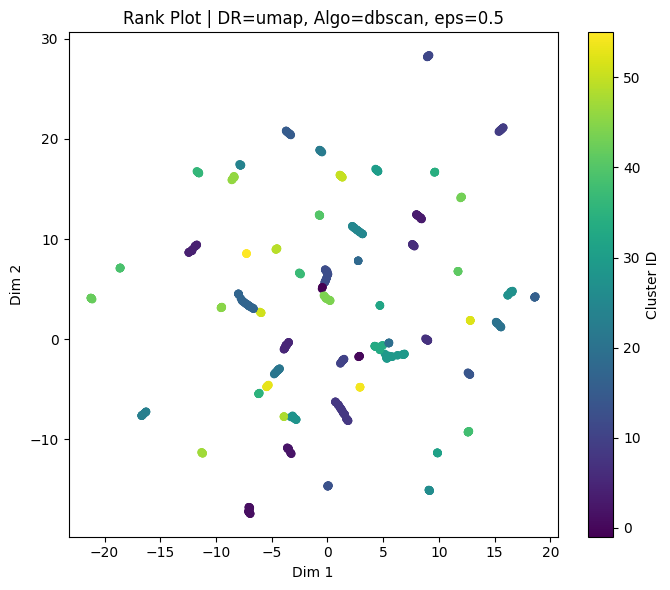

In [9]:
topN = 5
top = bench.head(topN).copy()
print("===== TOP 5 BEST CLUSTERING COMBINATIONS =====")
display(top)

for rank, row in top.iterrows():
    dr = row["DR"]
    algo = row["Clustering"]
    params = row["Params"]

    k_tmp, eps_tmp = 3, 0.8
    if str(params).startswith("k="):
        k_tmp = int(str(params).split("=")[1])
    if str(params).startswith("eps="):
        eps_tmp = float(str(params).split("=")[1])

    X_tmp = get_dr_embeddings(X_train_scaled, method=dr, random_state=42)
    labels_tmp = run_clustering(X_tmp, algo=algo, k=k_tmp, eps=eps_tmp, random_state=42)

    if dr != "none":
        plot_2d(X_tmp, labels_tmp, f"Rank Plot | DR={dr}, Algo={algo}, {params}")
    else:
        print(f"DR=none for rank plot (no 2D). DR={dr}, Algo={algo}, {params}")


## **10.Pick BEST setup + plot it**

In [10]:
best = bench.iloc[0]
best_dr = best["DR"]
best_algo = best["Clustering"]
best_params = best["Params"]

k_best, eps_best = 3, 0.8
if str(best_params).startswith("k="):
    k_best = int(str(best_params).split("=")[1])
if str(best_params).startswith("eps="):
    eps_best = float(str(best_params).split("=")[1])

print("✅ BEST CONFIG:")
print(best)

X_best_2d = get_dr_embeddings(X_train_scaled, method=best_dr, random_state=42)
labels_best = run_clustering(X_best_2d, algo=best_algo, k=k_best, eps=eps_best, random_state=42)

if best_dr != "none":
    plot_2d(X_best_2d, labels_best, f"BEST | DR={best_dr} Algo={best_algo} {best_params}")
else:
    print("Best DR=none → choose PCA/UMAP for plotting.")


✅ BEST CONFIG:
DR                       none
Clustering             dbscan
Params                eps=0.3
Silhouette(↑)        0.988098
DBI(↓)               0.019059
CH(↑)            10570.870902
NumClusters                 3
Name: 0, dtype: object
Best DR=none → choose PCA/UMAP for plotting.


## **11.Interpret clusters as Low/Medium/High risk**

In [11]:
train_df = pd.DataFrame(X_train_imp, columns=feature_names)
train_df["cluster_id"] = labels_best
train_df[target_col] = y_train.reset_index(drop=True).values  # for interpretation only

# Build summary (show this to sir)
summary = train_df.groupby("cluster_id").agg(
    n=(target_col, "count"),
    disease_rate=(target_col, "mean"),
    mean_age=("age", "mean") if "age" in train_df.columns else (feature_names[0], "mean"),
    mean_chol=("chol", "mean") if "chol" in train_df.columns else (feature_names[0], "mean"),
    mean_trestbps=("trestbps", "mean") if "trestbps" in train_df.columns else (feature_names[0], "mean"),
    mean_oldpeak=("oldpeak", "mean") if "oldpeak" in train_df.columns else (feature_names[0], "mean"),
    mean_thalach=("thalach", "mean") if "thalach" in train_df.columns else (feature_names[0], "mean"),
    mean_exang=("exang", "mean") if "exang" in train_df.columns else (feature_names[0], "mean"),
).reset_index()

# Risk score (feature-based; Outcome not used to create score)
# Higher age/chol/trestbps/oldpeak/exang => higher risk
# Lower thalach => higher risk, so use negative rank for thalach
def safe_rank(col):
    return summary[col].rank(pct=True) if col in summary.columns else 0

summary["risk_score"] = (
    safe_rank("mean_age") +
    safe_rank("mean_chol") +
    safe_rank("mean_trestbps") +
    safe_rank("mean_oldpeak") +
    safe_rank("mean_exang") +
    (1 - safe_rank("mean_thalach"))  # inverse
)

summary = summary.sort_values("risk_score").reset_index(drop=True)

if len(summary) == 3:
    risk_labels = ["Low-risk", "Medium-risk", "High-risk"]
elif len(summary) == 2:
    risk_labels = ["Low-risk", "High-risk"]
else:
    risk_labels = ["Single-group"] * len(summary)

summary["risk_label"] = risk_labels[:len(summary)]

print("===== CLUSTER INTERPRETATION TABLE  =====")
display(summary)

cluster_to_risk = dict(zip(summary["cluster_id"], summary["risk_label"]))
print("Cluster → Risk mapping:", cluster_to_risk)


===== CLUSTER INTERPRETATION TABLE  =====


,cluster_id,n,disease_rate,mean_age,mean_chol,mean_trestbps,mean_oldpeak,mean_thalach,mean_exang,risk_score,risk_label
0,1,5,1.000000,38.000000,175.000000,138.000000,0.000000,173.000000,0.000000,2.166667,Low-risk
1,0,5,1.000000,45.400000,238.800000,138.000000,0.120000,152.000000,1.000000,4.166667,Medium-risk
2,-1,810,0.507407,54.774074,248.440741,132.279012,1.090494,149.216049,0.338272,4.666667,High-risk


Cluster → Risk mapping: {1: 'Low-risk', 0: 'Medium-risk', -1: 'High-risk'}


/content/diabetes.csv

## **12.Plot again with risk labels written on clusters**





In [12]:
if best_dr != "none":
    plt.figure(figsize=(8,7))
    plt.scatter(X_best_2d[:,0], X_best_2d[:,1], c=labels_best, s=25)
    plt.title(f"Clusters with Risk Labels | DR={best_dr}, Algo={best_algo}, {best_params}")
    plt.xlabel("Dim1"); plt.ylabel("Dim2")
    plt.colorbar(label="Cluster ID")

    for cid in np.unique(labels_best):
        pts = X_best_2d[labels_best == cid]
        cx, cy = pts.mean(axis=0)
        plt.text(cx, cy, cluster_to_risk.get(cid, f"Cluster {cid}"), fontsize=12, weight="bold")

    plt.tight_layout()
    plt.show()
else:
    print("Best DR=none → use PCA/UMAP for 2D visualization.")


Best DR=none → use PCA/UMAP for 2D visualization.


## **extra plots**

> Add blockquote



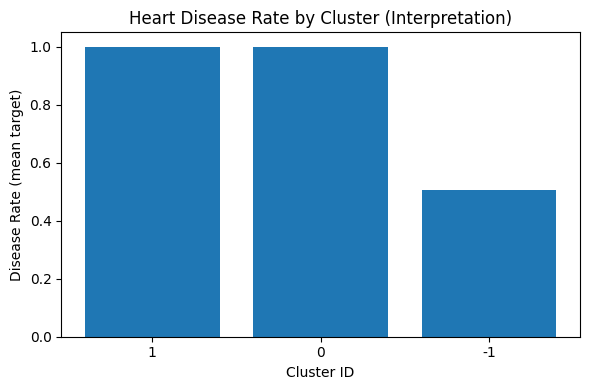

/tmp/ipython-input-2116086868.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cid) for cid in sorted(train_df["cluster_id"].unique())])


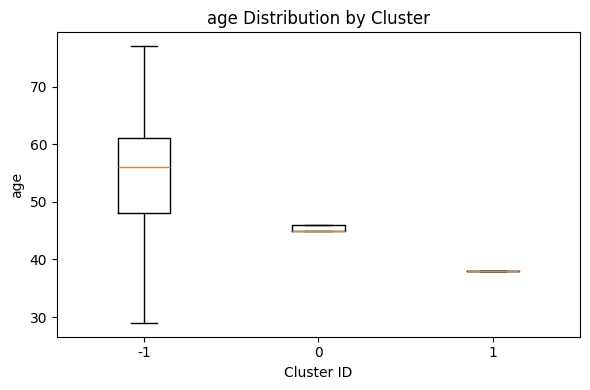

/tmp/ipython-input-2116086868.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cid) for cid in sorted(train_df["cluster_id"].unique())])


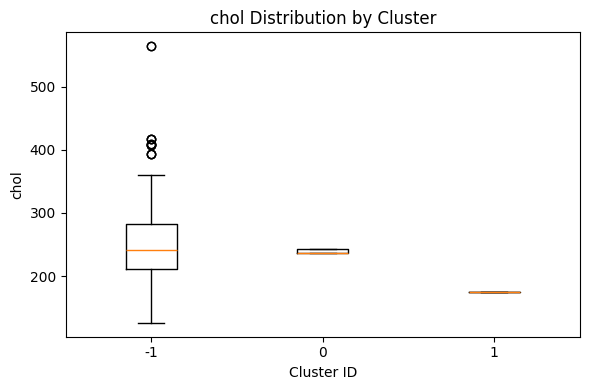

/tmp/ipython-input-2116086868.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cid) for cid in sorted(train_df["cluster_id"].unique())])


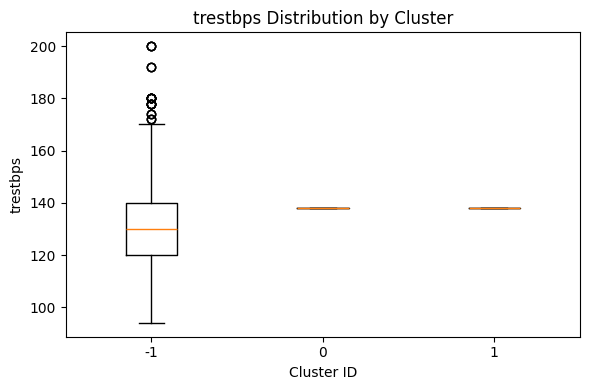

/tmp/ipython-input-2116086868.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cid) for cid in sorted(train_df["cluster_id"].unique())])


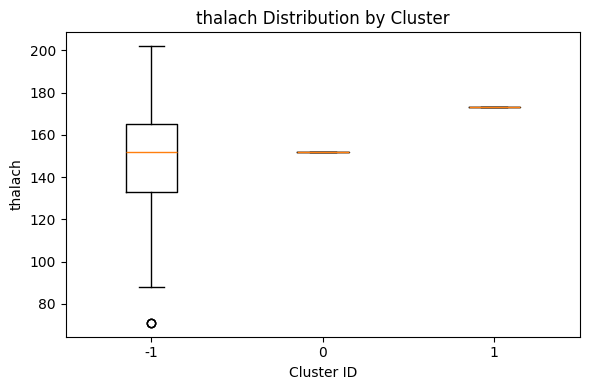

/tmp/ipython-input-2116086868.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(cid) for cid in sorted(train_df["cluster_id"].unique())])


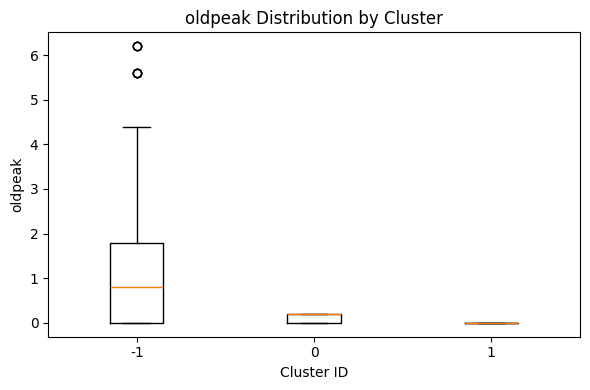

In [13]:
# Disease rate by cluster
plt.figure(figsize=(6,4))
plt.bar(summary["cluster_id"].astype(str), summary["disease_rate"])
plt.title("Heart Disease Rate by Cluster (Interpretation)")
plt.xlabel("Cluster ID")
plt.ylabel("Disease Rate (mean target)")
plt.tight_layout()
plt.show()

# Boxplots for key risk features (only if present)
features_to_show = [c for c in ["age", "chol", "trestbps", "thalach", "oldpeak"] if c in train_df.columns]

for f in features_to_show:
    plt.figure(figsize=(6,4))
    data = [train_df[train_df["cluster_id"]==cid][f].values for cid in sorted(train_df["cluster_id"].unique())]
    plt.boxplot(data, labels=[str(cid) for cid in sorted(train_df["cluster_id"].unique())])
    plt.title(f"{f} Distribution by Cluster")
    plt.xlabel("Cluster ID")
    plt.ylabel(f)
    plt.tight_layout()
    plt.show()


## **14.Cluster-as-feature + Classification comparison**

In [14]:
cluster_k = k_best if best_algo in ["kmeans", "hierarchical"] else 3

kmeans_feat = KMeans(n_clusters=cluster_k, random_state=42, n_init="auto")
train_cluster_feat = kmeans_feat.fit_predict(X_train_scaled)
test_cluster_feat  = kmeans_feat.predict(X_test_scaled)

X_train_plus = np.column_stack([X_train_scaled, train_cluster_feat])
X_test_plus  = np.column_stack([X_test_scaled,  test_cluster_feat])

models = [
    ("LogReg", LogisticRegression(max_iter=3000)),
    ("RandomForest", RandomForestClassifier(n_estimators=400, random_state=42)),
    ("XGBoost", XGBClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=4,
        subsample=0.9, colsample_bytree=0.9,
        random_state=42, eval_metric="logloss"
    ))
]

def eval_models(Xtr, Xte, ytr, yte, title):
    print("\n====", title, "====")
    rows = []
    for name, model in models:
        model.fit(Xtr, ytr)
        pred = model.predict(Xte)
        acc = accuracy_score(yte, pred)
        f1 = f1_score(yte, pred)
        rows.append([name, acc, f1])
        print(f"{name}: Accuracy={acc:.4f}, F1={f1:.4f}")
    return pd.DataFrame(rows, columns=["Model","Accuracy","F1"])

base = eval_models(X_train_scaled, X_test_scaled, y_train, y_test, "WITHOUT cluster feature")
plus = eval_models(X_train_plus,  X_test_plus,  y_train, y_test, "WITH cluster feature")

final = base.merge(plus, on="Model", suffixes=("_NoCluster", "_WithCluster"))
final["Acc_Improve"] = final["Accuracy_WithCluster"] - final["Accuracy_NoCluster"]
final["F1_Improve"]  = final["F1_WithCluster"] - final["F1_NoCluster"]

print("\n===== FINAL COMPARISON TABLE =====")
display(final.sort_values("Acc_Improve", ascending=False))



==== WITHOUT cluster feature ====
LogReg: Accuracy=0.8098, F1=0.8312
RandomForest: Accuracy=1.0000, F1=1.0000
XGBoost: Accuracy=1.0000, F1=1.0000

==== WITH cluster feature ====
LogReg: Accuracy=0.8195, F1=0.8384
RandomForest: Accuracy=1.0000, F1=1.0000
XGBoost: Accuracy=1.0000, F1=1.0000

===== FINAL COMPARISON TABLE =====


,Model,Accuracy_NoCluster,F1_NoCluster,Accuracy_WithCluster,F1_WithCluster,Acc_Improve,F1_Improve
0,LogReg,0.809756,0.831169,0.819512,0.838428,0.009756,0.007259
1,RandomForest,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
2,XGBoost,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000


## **15. 5-Fold Cross Validation (strong evidence for validity)**

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_score(model, X, y):
    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy").mean()
    f1  = cross_val_score(model, X, y, cv=cv, scoring="f1").mean()
    return acc, f1

rows = []
for name, model in models:
    acc, f1 = cv_score(model, X_train_scaled, y_train)
    rows.append([name, "NoCluster", acc, f1])

for name, model in models:
    acc, f1 = cv_score(model, X_train_plus, y_train)
    rows.append([name, "WithCluster", acc, f1])

cv_df = pd.DataFrame(rows, columns=["Model","Setting","CV_Accuracy","CV_F1"])
print("===== 5-FOLD CV RESULTS =====")
display(cv_df)


===== 5-FOLD CV RESULTS =====


,Model,Setting,CV_Accuracy,CV_F1
0,LogReg,NoCluster,0.842683,0.854985
1,RandomForest,NoCluster,0.981707,0.982156
2,XGBoost,NoCluster,0.985366,0.985753
3,LogReg,WithCluster,0.846341,0.855762
4,RandomForest,WithCluster,0.984146,0.984646
5,XGBoost,WithCluster,0.987805,0.988104


## **16.Confusion Matrix**

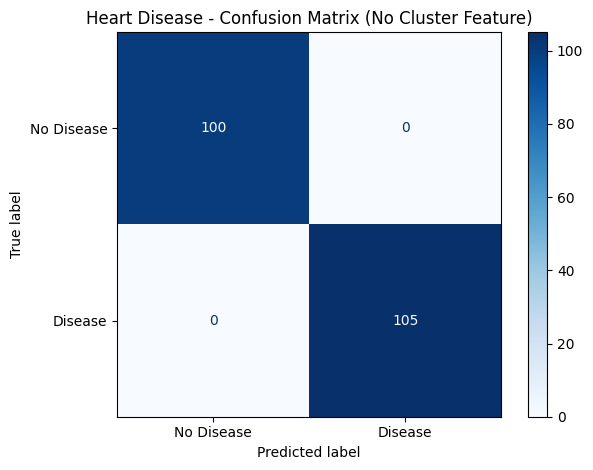

=== Heart Disease Report (No Cluster) ===
              precision    recall  f1-score   support

  No Disease       1.00      1.00      1.00       100
     Disease       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



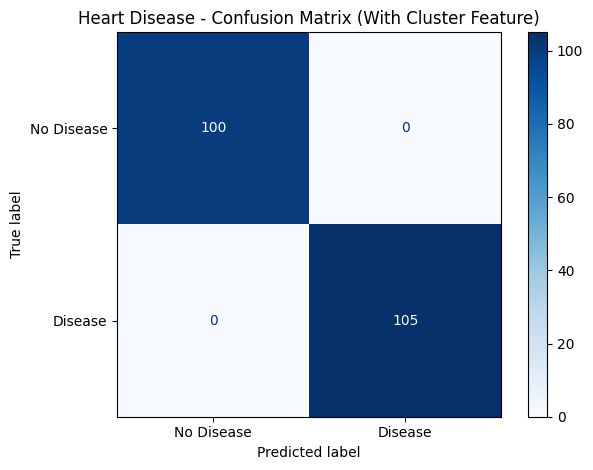

=== Heart Disease Report (With Cluster) ===
              precision    recall  f1-score   support

  No Disease       1.00      1.00      1.00       100
     Disease       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

def plot_cm(y_true, y_pred, title, labels=("No Disease", "Disease")):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=list(labels))
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# ---- Case A: WITHOUT cluster feature ----
model_no = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, eval_metric="logloss"
)
model_no.fit(X_train_scaled, y_train)
pred_no = model_no.predict(X_test_scaled)

plot_cm(y_test, pred_no, "Heart Disease - Confusion Matrix (No Cluster Feature)")
print("=== Heart Disease Report (No Cluster) ===")
print(classification_report(y_test, pred_no, target_names=["No Disease", "Disease"]))

# ---- Case B: WITH cluster feature ----
model_yes = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, eval_metric="logloss"
)
model_yes.fit(X_train_plus, y_train)
pred_yes = model_yes.predict(X_test_plus)

plot_cm(y_test, pred_yes, "Heart Disease - Confusion Matrix (With Cluster Feature)")
print("=== Heart Disease Report (With Cluster) ===")
print(classification_report(y_test, pred_yes, target_names=["No Disease", "Disease"]))


## **presion/recall/F1**

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier

print("=== Sanity check ===")
print("y_test unique:", sorted(set(y_test)))
print("X_test_scaled shape:", X_test_scaled.shape)
print("X_test_plus shape  :", X_test_plus.shape)

# -------------------------
# Case A: WITHOUT cluster feature
# -------------------------
model_no = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, eval_metric="logloss"
)
model_no.fit(X_train_scaled, y_train)
pred_no = model_no.predict(X_test_scaled)

print("\n==============================")
print("HEART - WITHOUT Cluster Feature")
print("==============================")
print("Precision:", precision_score(y_test, pred_no, zero_division=0))
print("Recall   :", recall_score(y_test, pred_no, zero_division=0))
print("F1-score :", f1_score(y_test, pred_no, zero_division=0))
print("\nClassification report:")
print(classification_report(y_test, pred_no, target_names=["No Disease", "Disease"], zero_division=0))

# -------------------------
# Case B: WITH cluster feature
# -------------------------
model_yes = XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=4,
    subsample=0.9, colsample_bytree=0.9,
    random_state=42, eval_metric="logloss"
)
model_yes.fit(X_train_plus, y_train)
pred_yes = model_yes.predict(X_test_plus)

print("\n==============================")
print("HEART - WITH Cluster Feature")
print("==============================")
print("Precision:", precision_score(y_test, pred_yes, zero_division=0))
print("Recall   :", recall_score(y_test, pred_yes, zero_division=0))
print("F1-score :", f1_score(y_test, pred_yes, zero_division=0))
print("\nClassification report:")
print(classification_report(y_test, pred_yes, target_names=["No Disease", "Disease"], zero_division=0))


=== Sanity check ===
y_test unique: [0, 1]
X_test_scaled shape: (205, 13)
X_test_plus shape  : (205, 14)

HEART - WITHOUT Cluster Feature
Precision: 1.0
Recall   : 1.0
F1-score : 1.0

Classification report:
              precision    recall  f1-score   support

  No Disease       1.00      1.00      1.00       100
     Disease       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205


HEART - WITH Cluster Feature
Precision: 1.0
Recall   : 1.0
F1-score : 1.0

Classification report:
              precision    recall  f1-score   support

  No Disease       1.00      1.00      1.00       100
     Disease       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



In [18]:
from sklearn.metrics import roc_auc_score

auc_no = roc_auc_score(y_test, pred_no)
auc_yes = roc_auc_score(y_test, pred_yes)

print("AUC without cluster:", auc_no)
print("AUC with cluster   :", auc_yes)


AUC without cluster: 1.0
AUC with cluster   : 1.0
